In [1]:
import os
import numpy as np
import pandas as pd
import librosa
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from IPython.display import Audio
import torch
import pandas as pd
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt


## Extraemos ejemplo

In [2]:

file_path = './project-4-whale-calls/train/train/1.wav'  
y, sr = librosa.load(file_path, sr=2000)  

plt.figure(figsize=(10, 4))
librosa.display.waveshow(y, sr=sr)
plt.title('Waveform')
plt.show()

Audio(data=y, rate=sr)

/Users/jleandrojm/anaconda3/lib/python3.11/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


FileNotFoundError: [Errno 2] No such file or directory: './project-4-whale-calls/train/train/1.wav'

## Extraccion de carcteristicas

In [22]:
import os
import numpy as np
import pandas as pd

def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=2000)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfccs_mean = np.mean(mfccs, axis=1)
    return mfccs_mean

def encode(data_dir, csv_file):
    df = pd.read_csv(os.path.join(data_dir, csv_file))
    data = []
    labels = []
    
    for index, row in df.iterrows():
        file_name = f"train/train/{row['idx']}.wav"
        file_path = os.path.join(data_dir, file_name)
        if os.path.exists(file_path):
            features = extract_features(file_path)
            data.append(features)
            labels.append(1 if row['class'] == 'RightWhale' else 0)
    
    data = np.array(data)
    labels = np.array(labels)
    return data, labels


In [11]:
import os
import librosa
import numpy as np
import pandas as pd
from concurrent.futures import ThreadPoolExecutor

def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=2000)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfccs_mean = np.mean(mfccs, axis=1)
    return mfccs_mean

def process_row(row, data_dir):
    file_name = f"train/train/{row['idx']}.wav"
    file_path = os.path.join(data_dir, file_name)
    if os.path.exists(file_path):
        features = extract_features(file_path)
        label = 1 if row['class'] == 'RightWhale' else 0
        return features, label
    return None

def encode(data_dir, csv_file, max_workers=4):
    df = pd.read_csv(os.path.join(data_dir, csv_file))
    data = []
    labels = []

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [executor.submit(process_row, row, data_dir) for _, row in df.iterrows()]
        for future in futures:
            result = future.result()
            if result:
                features, label = result
                data.append(features)
                labels.append(label)
    
    data = np.array(data)
    labels = np.array(labels)
    return data, labels



In [23]:
data_dir = './data'
train_csv = 'train.csv'

x, y = encode(data_dir, train_csv)


# x, y = encode(data_dir, train_csv, max_workers=4)

### Aplicamos normalizacion

In [1]:
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

NameError: name 'StandardScaler' is not defined

### Aplicamos PCA como reduccion de dimensioalidad

In [94]:
pca = PCA()
pca.fit(x_scaled)

PCA()

Número óptimo de componentes principales: 11


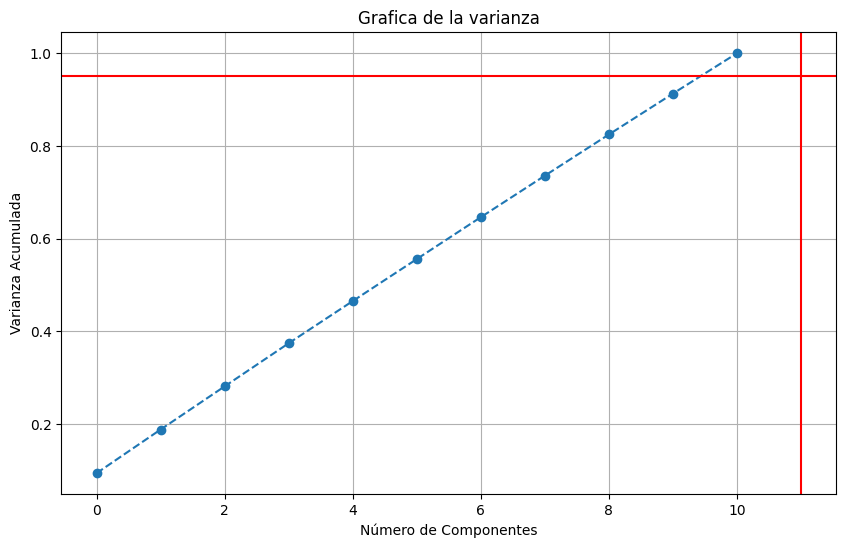

In [95]:

cumulative_variance = np.cumsum(pca.explained_variance_ratio_)


n_components = np.argmax(cumulative_variance >= 0.95) + 1

print(f'Número óptimo de componentes principales: {n_components}')

plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance, marker='o', linestyle='--')
plt.axhline(y=0.95, color='r', linestyle='-')
plt.axvline(x=n_components, color='r', linestyle='-')
plt.title('Grafica de la varianza')
plt.xlabel('Número de Componentes')
plt.ylabel('Varianza Acumulada')
plt.grid(True)
plt.show()

In [96]:
pca = PCA(n_components=n_components)
x_pca = pca.fit_transform(x_scaled)

### Realizamos split para tener train y test

In [97]:
x_train, x_test, y_train, y_test = train_test_split(x_pca, y, test_size=0.2, random_state=42)


### Prueba de modelo
con reduccion y normalizacion sale mejor

In [98]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(x_train, y_train)


y_pred = model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-Score: {f1}')

Accuracy: 0.796875
Precision: 0.8103837471783296
Recall: 0.7855579868708972
F1-Score: 0.7977777777777778


In [99]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
x = torch.tensor(x_train, dtype=torch.float32)
y = torch.tensor(y_train, dtype=torch.float32)

x_t = torch.tensor(x_test, dtype=torch.float32)
y_t = torch.tensor(y_test, dtype=torch.float32)

# Move the tensors to the GPU if available
x = x.to(device)
y = y.to(device)
x_t = x_t.to(device)
y_t = y_t.to(device)

# Write your code here
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)


cpu
cpu


/var/folders/tl/mr1w7dxx4z94s5hwlh_ncdb40000gn/T/ipykernel_7140/3340043487.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y_train, dtype=torch.float32)
/var/folders/tl/mr1w7dxx4z94s5hwlh_ncdb40000gn/T/ipykernel_7140/3340043487.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_t = torch.tensor(y_test, dtype=torch.float32)


In [100]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.dropout1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.dropout2(out)
        out = self.fc3(out)
        out = self.relu3(out)
        out = self.fc4(out)
        return out


In [103]:
loss_fn = nn.BCEWithLogitsLoss()
input_size = 11  # Cambiar a 11 para coincidir con las características de entrada
hidden_size = 30
model1 = MLP(input_size, hidden_size).to(device)

optimizer1 = torch.optim.Adam(model1.parameters(), lr=0.01, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer1, step_size=1000, gamma=0.5)

In [104]:
def train(model, loss_f, optimizer, scheduler, epochs, x_train, y_train, device):
    loss_lista = []
    for epoch in range(epochs):
        x_train = x_train.to(device)
        y_train = y_train.to(device).view(-1, 1)

        y_pred = model(x_train)
        loss = loss_f(y_pred, y_train)
        loss_lista.append(loss.cpu().item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        if epoch % 500 == 0:
            print('Epoch {}: train loss: {}'.format(epoch, loss.item()))

    return loss_lista

In [105]:
loss_list1 = train(model1, loss_fn, optimizer1, scheduler, epochs=4000, x_train=x, y_train=y, device=device)

Epoch 0: train loss: 0.6938531398773193
Epoch 500: train loss: 0.3929561674594879
Epoch 1000: train loss: 0.3808613121509552
Epoch 1500: train loss: 0.3719414472579956
Epoch 2000: train loss: 0.378216952085495
Epoch 2500: train loss: 0.3715207278728485
Epoch 3000: train loss: 0.3675742745399475
Epoch 3500: train loss: 0.3542785942554474


In [106]:
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns



def matriz_confusion(y_test, y_pred, Tipo):
    # Calcular la matriz de confusión
    matrix = confusion_matrix(y_test, y_pred)
    
    f2 = pd.DataFrame(matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis], index=["NoWhale", "RightWhale"], columns=["NoWhale", "RightWhale"])
    
    # Graficar la matriz de confusión
    sns.heatmap(f2, annot=True, cbar=None, cmap="Greens")
    plt.title("Confusion Matrix " + Tipo), plt.tight_layout()
    plt.xlabel("Predicted")
    plt.ylabel("Real")
    plt.show()

F1 Score: 0.8099173553719008
Precision: 0.7671232876712328
Recall: 0.8577680525164114


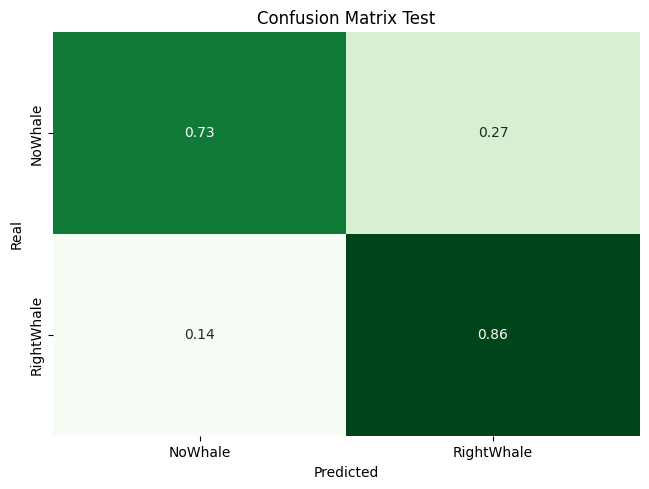

In [107]:

def test(model, x_test, y_test):
    model.eval()
    x_test = x_test.to(device).float()
    y_test = y_test.to(device).float().unsqueeze(1)
    with torch.no_grad():
        y_pred = model(x_test)
        y_pred_labels = torch.sigmoid(y_pred) >= 0.5

    y_test_labels = y_test.squeeze().cpu().numpy()
    y_pred_labels = y_pred_labels.squeeze().cpu().numpy()

    f1 = f1_score(y_test_labels, y_pred_labels)
    precision = precision_score(y_test_labels, y_pred_labels)
    recall = recall_score(y_test_labels, y_pred_labels)

    print(f'F1 Score: {f1}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    matriz_confusion(y_test_labels, y_pred_labels, "Test")

test(model1, x_t, y_t)

In [31]:
def process_file(file_path):
    if os.path.exists(file_path):
        return extract_features(file_path)
    return None

def process_audio_files(data_dir, max_workers=4):
    data = []
    file_paths = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.wav')]
    
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [executor.submit(process_file, file_path) for file_path in file_paths]
        for future in futures:
            result = future.result()
            if result is not None:
                data.append(result)
    
    data = np.array(data)
    return data

def normalize_data(data):
    scaler = StandardScaler()
    normalized_data = scaler.fit_transform(data)
    return normalized_data

# Uso de las funciones
data_dir_test = './data/test/test'
data = process_audio_files(data_dir_test, max_workers=4)


normalized_data = normalize_data(data)


In [33]:
print(normalized_data)

[[-1.8460145  -0.26384783 -0.8858121  ...  1.2017711   0.50243306
   0.22365233]
 [-0.8470617   0.6785748   3.8930187  ... -0.70231104  1.951747
  -3.9341671 ]
 [ 0.6704905   0.3938366  -0.400433   ...  1.1487035   1.1753774
   1.7686309 ]
 ...
 [ 0.00534916  0.18076952  1.6801839  ... -0.6938517  -0.06410016
  -0.5263276 ]
 [ 1.2781731   0.20758133  0.4267894  ...  0.7073624   0.89651024
   0.29122666]
 [ 1.2066556  -0.20075265 -0.5216731  ...  0.21827571  0.2699943
   0.7665981 ]]


In [36]:
pca = PCA(n_components=11)
x_pca = pca.fit_transform(normalized_data)

In [109]:

# Convertir los datos normalizados a tensores de PyTorch
data_tensor = torch.tensor(x_pca, dtype=torch.float32)

# Realizar predicciones
with torch.no_grad():
    model1.eval()  # Asegúrate de que el modelo esté en modo evaluación si no lo está ya
    outputs = model1(data_tensor)
    predictions = torch.sigmoid(outputs).numpy().flatten()
    predicted_classes = ['RightWhale' if pred >= 0.5 else 'NoWhale' for pred in predictions]

# Crear un DataFrame con las predicciones y guardar en CSV
results_df = pd.DataFrame({'idx': range(len(predicted_classes)), 'class': predicted_classes})
results_df.to_csv('predictions.csv', index=False)

print("Predicciones guardadas en predictions.csv")


Predicciones guardadas en predictions.csv


In [24]:
# Normalización
scaler = StandardScaler()
x_scaled = [scaler.fit_transform(sequence) for sequence in x]
# Convertir a tensores
x_tensor = [torch.tensor(sequence, dtype=torch.float32) for sequence in x_scaled]
y_tensor = torch.tensor(y, dtype=torch.float32)
# División de datos en train y test
x_train, x_test, y_train, y_test = train_test_split(x_tensor, y_tensor, test_size=0.3, random_state=42)

ValueError: Expected 2D array, got 1D array instead:
array=[-267.22052     -2.2850366  -58.037872    30.968853   -53.20267
   30.096142   -22.377308     2.7980556    2.731711    -8.680118
   -2.611308    -1.6252785  -14.680113 ].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [25]:
from sklearn.preprocessing import StandardScaler
import torch
from sklearn.model_selection import train_test_split

# Normalización
scaler = StandardScaler()
x_scaled = [scaler.fit_transform(sequence.reshape(-1, 1)) for sequence in x]

# Convertir a tensores
x_tensor = [torch.tensor(sequence, dtype=torch.float32) for sequence in x_scaled]

# Como cada secuencia ahora es una matriz 2D, necesitamos aplanarlas de nuevo para el modelado
x_tensor = [sequence.view(-1) for sequence in x_tensor]

# Convertir y a tensor
y_tensor = torch.tensor(y, dtype=torch.float32)

# División de datos en train y test
x_train, x_test, y_train, y_test = train_test_split(x_tensor, y_tensor, test_size=0.3, random_state=42)

# Si x_tensor tiene una estructura más compleja, podrías necesitar ajustar el view/reshape
# Por ejemplo, si x_tensor tiene más de una característica por secuencia, necesitarías manejarlo adecuadamente


In [52]:
class ImprovedLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_prob=0.5):
        super(ImprovedLSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob)
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        return out

In [53]:
# Hiperparámetros
input_size = 1  # Ajusta esto según tus datos
hidden_size = 64
num_layers = 2
output_size = 1
learning_rate = 0.001
num_epochs = 50

In [54]:
model = ImprovedLSTMModel(input_size, hidden_size, num_layers, output_size)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [55]:
def train(model, optimizer, criterion, x_train, y_train, num_epochs=20):
    model.train()
    for epoch in range(num_epochs):
        for i in range(len(x_train)):
            inputs = x_train[i].unsqueeze(0)  # Ajuste para que tenga la forma [1, seq_len, input_size]
            labels = y_train[i].unsqueeze(0).unsqueeze(0)  # [1, 1]
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        if (epoch+1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

In [56]:
def evaluate(model, x_test, y_test):
    model.eval()
    with torch.no_grad():
        predictions = []
        actuals = []
        for i in range(len(x_test)):
            inputs = x_test[i].unsqueeze(0)  # Ajuste para que tenga la forma [1, seq_len, input_size]
            labels = y_test[i].unsqueeze(0).unsqueeze(0)  # [1, 1]
            
            outputs = model(inputs)
            predictions.append(torch.sigmoid(outputs).item())
            actuals.append(labels.item())
    
    predictions = np.array(predictions) >= 0.5
    actuals = np.array(actuals)
    accuracy = np.mean(predictions == actuals)
    print(f'Accuracy: {accuracy:.4f}')

In [57]:
scaler = StandardScaler()
x_scaled = [scaler.fit_transform(sequence.reshape(-1, 1)) for sequence in x]
x_tensor = [torch.tensor(sequence, dtype=torch.float32) for sequence in x_scaled]
y_tensor = torch.tensor(y, dtype=torch.float32)

# División de datos en train y test
x_train, x_test, y_train, y_test = train_test_split(x_tensor, y_tensor, test_size=0.3, random_state=42)

# Entrenamiento del modelo
train(model, optimizer, criterion, x_train, y_train, num_epochs)

# Evaluación del modelo
evaluate(model, x_test, y_test)

Epoch [5/50], Loss: 0.4247
Epoch [10/50], Loss: 0.3163
Epoch [15/50], Loss: 0.2490
Epoch [20/50], Loss: 0.4359
Epoch [25/50], Loss: 0.1852
Epoch [30/50], Loss: 0.1743
Epoch [35/50], Loss: 0.1397
Epoch [40/50], Loss: 0.3086
Epoch [45/50], Loss: 0.1902
Epoch [50/50], Loss: 0.2469
Accuracy: 0.8132


In [67]:
def generate_predictions(model, data, output_csv='predictions.csv'):
    model.eval()
    with torch.no_grad():
        predictions = []
        for sequence in data:
            tensor_data = torch.tensor(sequence, dtype=torch.float32).unsqueeze(0)  # [1, seq_len, input_size]
            outputs = model(tensor_data)
            pred = torch.sigmoid(outputs).item()
            predictions.append('RightWhale' if pred >= 0.5 else 'NoWhale')

    results_df = pd.DataFrame({'idx': range(len(predictions)), 'class': predictions})
    results_df.to_csv(output_csv, index=False)
    print(f'Predicciones guardadas en {output_csv}')

# Datos de test para predicción (ajusta según tus datos reales)
test_data = normalized_data

# Normalización de datos de test
test_data_scaled = [scaler.transform(sequence.reshape(-1, 1)) for sequence in test_data]

# Generación de predicciones
generate_predictions(model, test_data_scaled)

Predicciones guardadas en predictions.csv
